In [1]:
import rebound
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import astropy.constants as c
import copy
from IPython.display import display, clear_output


%matplotlib inline

In [2]:
def newtonsMethod(f, fdot, x, precission=0.01):
    while abs(0-f(x)) > precission:
        x = x - f(x)/fdot(x)
    return x

def keplersEq(E, M, e):
    return E - e*np.sin(E)-M

def keplersEqDot(E, M, e):
    return 1 - e*np.cos(E)
    
def guessE(M, e):
    return M + 0.85*e*np.sign(np.sin(M))

def newtonKeplerSolver(M, e, precission=0.0001):
    E = guessE(M, e)
    f = lambda E: keplersEq(E, M, e)
    fdot = lambda E: keplersEqDot(E, M, e)
    return newtonsMethod(f, fdot, E, precission=precission)

In [3]:
mjup2msun_convert = (c.M_jup/c.M_sun).value
mearth2msun_convert = (c.M_earth/c.M_sun).value

star = {"m":0.334}

#exoplanet.eu
#planetc = {"m":0.856*msun2mjup_convert, "e":0.002, "a":0.12959000, "inc":48.07, "omega":225.2, "l":0}
#planetb = {"m":1.938*msun2mjup_convert, "e":0.000, "a":0.20831700, "inc":84.00, "omega":116.7, "l":0}
#planete = {"m":0.045*msun2mjup_convert, "e":0.073, "a":0.33430000, "inc":59.50, "omega":360.0, "l":0}
#planetd = {"m":0.022*msun2mjup_convert, "e":0.081, "a":0.02080665, "inc":50.00, "omega":157.4, "l":0}

# google not best with parameters, look at rivera for i=90 to get enough usable parameters
# https://arxiv.org/pdf/1006.4244.pdf
planetd = {"m":6.83*mearth2msun_convert, "e":0.20700, "a":0.02080665, "inc":1.02974, "omega":4.08,  "M":6.2}
planetc = {"m":0.7142*mjup2msun_convert, "e":0.25591, "a":0.12959000, "inc":1.02974, "omega":0.851, "M":5.14}
planetb = {"m":2.2756*mjup2msun_convert, "e":0.03240, "a":0.20831700, "inc":1.02974, "omega":0.878, "M":5.68}
planete = {"m":14.6*mearth2msun_convert, "e":0.05500, "a":0.33430000, "inc":1.02974, "omega":4.17,  "M":5.85}

# http://astronomyonline.org/Exoplanets/Gliese876.asp#Gliese876
#planetc = {"m":265.6*mearth2msun_convert, "e":0.2571, "a":0.136044, "inc":53.06, "omega":51.09, "Omega":0}
#planetb = {"m":845.2*mearth2msun_convert, "e":0.0325, "a":0.218627, "inc":53.06, "omega":35.50, "Omega":0}
#planete = {"m":15.80*mearth2msun_convert, "e":0.0300, "a":0.350100, "inc":53.06, "omega":164.1, "Omega":0}
#planetd = {"m":7.550*mearth2msun_convert, "e":0.0570, "a":0.021838, "inc":53.06, "omega":116.0, "Omega":0}
planets = [ planetd, planetc, planetb, planete]

# period of closest planet is ~2 days so a 1000 orbits is ~2000 days
# https://rebound.readthedocs.io/en/latest/ipython/Units.html
# the default units are where G=1 (e.g., AU, M⊙, yr/2π)
# so a single timestep is in reference to yr/2pi = 365.256/2pi = 58.132297894 days
# to a good timestep to use is the T_closesPlanet/20 ~ 0.1days or 0.00172021412*dt
# so assuming we started from t=0 we need to integrate to t=10pi to get 2000 orbits of closest planet

In [4]:
planetd

{'m': 2.0513832252650918e-05,
 'e': 0.207,
 'a': 0.02080665,
 'inc': 1.02974,
 'omega': 4.08,
 'M': 6.2}

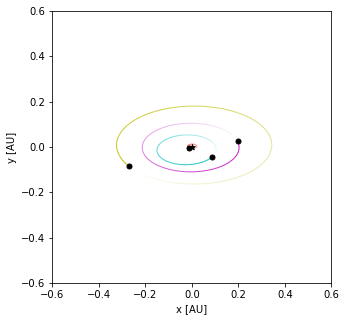

In [4]:
sim = rebound.Simulation()
sim.add(**star)
for planet in planets:
    sim.add(**planet)
sim.move_to_com()
fig = rebound.OrbitPlot(sim,color=True,unitlabel="[AU]",lim=0.6)

In [5]:
a, e = [[],[],[],[]], [[],[],[],[]]
for i in range(600):
    sim.integrate(sim.t+.01)
    for j, particle in enumerate(sim.particles):
        if j!=0:
            a[j-1].append(particle.a)
            e[j-1].append(particle.e)
    #fig = rebound.OrbitPlot(sim,color=True,unitlabel="[AU]",lim=0.6)
    #display(fig)
    #plt.close(fig)
    #clear_output(wait=True)

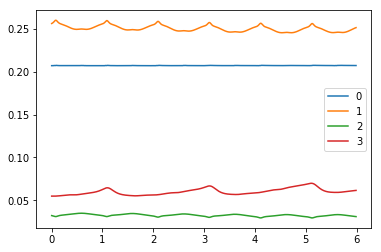

In [6]:
for i, ap in enumerate(e):
        plt.plot(np.arange(0, sim.t, 0.01), ap, label=i)
plt.legend()

In [7]:
sims = []
sim = rebound.Simulation()
for planet in planets:
        #planet["inc"] = i
        sim.add(**star)
        sim.add(**planet)
#rebound.OrbitPlot(sim)

#for i in np.arange(0, 80, 0.00172021412):
#    rebound.OrbitPlot(sim)
#    sim.integrate(sim.t+i)
#    time.sleep(1)

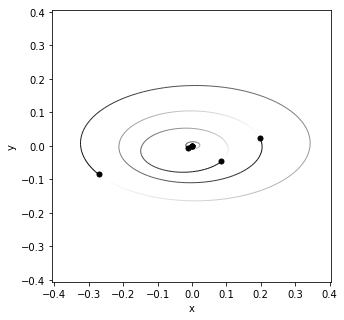

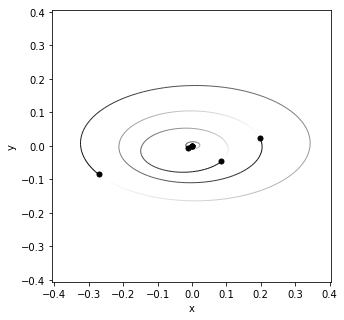

In [8]:
rebound.OrbitPlot(sim)

In [16]:
sim = rebound.Simulation()
sim.add(**star)
sim.add(**planetd)
sim.add(**planetc)
sim.add(**planetb)
sim.add(**planete)
sim.move_to_com()

In [17]:
N=100
transittimes = np.zeros(N)
p = sim.particles
i = 0
while i<N:
    y_old = p[2].y - p[0].y  # (Thanks to David Martin for pointing out a bug in this line!)
    t_old = sim.t
    sim.integrate(sim.t+0.5) # check for transits every 0.5 time units. Note that 0.5 is shorter than one orbit
    t_new = sim.t
    if y_old*(p[2].y-p[0].y)<0. and p[2].x-p[0].x>0.:   # sign changed (y_old*y<0), planet in front of star (x>0)
        while t_new-t_old>1e-7:   # bisect until prec of 1e-5 reached
            if y_old*(p[2].y-p[0].y)<0.:
                t_new = sim.t
            else:
                t_old = sim.t
            sim.integrate( (t_new+t_old)/2.)
        transittimes[i] = sim.t
        i += 1
        sim.integrate(sim.t+0.05)       # integrate 0.05 to be past the transit

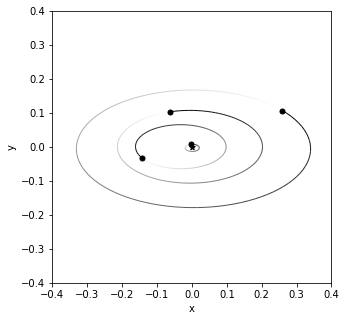

In [18]:
fig = rebound.OrbitPlot(sim)

In [19]:
A = np.vstack([np.ones(N), range(N)]).T
c, m = np.linalg.lstsq(A, transittimes)[0]

/home/dino/.conda/envs/exoplanets/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


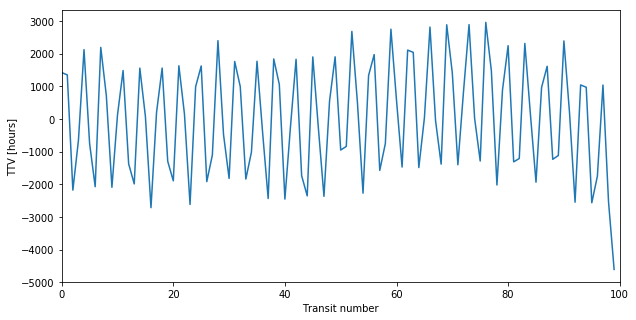

In [20]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)
ax.set_xlim([0,N])
ax.set_xlabel("Transit number")
ax.set_ylabel("TTV [hours]")
plt.plot(range(N), (transittimes-m*np.array(range(N))-c)*(24.*365./2./np.pi));